# Spike train decoding for brain-machine interface

For use in decoding, we need the following format of inputs:
- Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin
- The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In this example, we load Matlab data that contains 
- The spike times of all neurons. In Matlab, "spike_times" is a cell of size "number of neurons" x 1. Within spike_times{i} is a vector containing all the spike times of neuron i.
- A continuous stream of the output variables. In this example, we are aiming to decode velocity. In Matlab, "vels" is a matrix of size "number of recorded time points" x 2 (x and y velocities were recorded) that contains the x and y velocity components at all time points. "vel_times" is a vector that states the time at all recorded time points. 

#### Original content creator: Joshua I. Glaser


### Import packages

In [1]:
###Import standard packages###
import numpy as np
from scipy import io, stats
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv as inv #Used in kalman filter
from sklearn import linear_model

### Load Data

In [2]:
###Load Data###
folder='./Decoding_Data/'
data=io.loadmat(folder+'s1_data_raw.mat')
spike_times=data['spike_times'] #Load spike times of all neurons
vels=data['vels'] #Load x and y velocities
vel_times=data['vel_times'] #Load times at which velocities were recorded

In [3]:
print(spike_times.shape, vels.shape, vel_times.shape)

(52, 1) (306700, 2) (306700, 1)


### User Inputs

In [4]:
dt=.05 #Size of time bins (in seconds)
t_start=vel_times[0] #Time to start extracting data - here the first time velocity was recorded
t_end=vel_times[-1] #Time to finish extracting data - here the last time velocity was recorded
downsample_factor=1 #Downsampling of output (to make binning go faster). 1 means no downsampling.

### Functions for preprocessing

In [5]:
######## BIN_SPIKES ########
def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """
    Function that puts spikes into bins

    Parameters
    ----------
    spike_times: an array of arrays
        an array of neurons. within each neuron's array is an array containing all the spike times of that neuron
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins

    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    return neural_data


######## BIN_OUTPUT #######
def bin_output(outputs,output_times,dt,wdw_start,wdw_end,downsample_factor=1):
    """
    Function that puts outputs into bins

    Parameters
    ----------
    outputs: matrix of size "number of times the output was recorded" x "number of features in the output"
        each entry in the matrix is the value of the output feature
    output_times: a vector of size "number of times the output was recorded"
        each entry has the time the output was recorded
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for binning the outputs
    wdw_end: number (any format)
        the end time for binning the outputs
    downsample_factor: integer, optional, default=1
        how much to downsample the outputs prior to binning
        larger values will increase speed, but decrease precision

    Returns
    -------
    outputs_binned: matrix of size "number of time bins" x "number of features in the output"
        the average value of each output feature in every time bin
    """
    
    ###Downsample output###
    #We just take 1 out of every "downsample_factor" values#
    if downsample_factor!=1: #Don't downsample if downsample_factor=1
        downsample_idxs=np.arange(0,output_times.shape[0],downsample_factor) #Get the idxs of values we are going to include after downsampling
        outputs=outputs[downsample_idxs,:] #Get the downsampled outputs
        output_times=output_times[downsample_idxs] #Get the downsampled output times

    ###Put outputs into bins###
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    output_dim=outputs.shape[1] #Number of output features
    outputs_binned=np.empty([num_bins,output_dim]) #Initialize matrix of binned outputs
    #Loop through bins, and get the mean outputs in those bins
    for i in range(num_bins): #Loop through bins
        idxs=np.where((np.squeeze(output_times)>=edges[i]) & (np.squeeze(output_times)<edges[i+1]))[0] #Indices to consider the output signal (when it's in the correct time range)
        for j in range(output_dim): #Loop through output features
            outputs_binned[i,j]=np.mean(outputs[idxs,j])

    return outputs_binned


###$$ GET_SPIKES_WITH_HISTORY #####
def get_spikes_with_history(neural_data,bins_before,bins_after,bins_current=1):
    """
    Function that creates the covariate matrix of neural activity

    Parameters
    ----------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    bins_before: integer
        How many bins of neural data prior to the output are used for decoding
    bins_after: integer
        How many bins of neural data after the output are used for decoding
    bins_current: 0 or 1, optional, default=1
        Whether to use the concurrent time bin of neural data for decoding

    Returns
    -------
    X: a matrix of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
        For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after)
    """

    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_after+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = np.NaN
    #Loop through each time bin, and collect the spikes occurring in surrounding time bins
    #Note that the first "bins_before" and last "bins_after" rows of X will remain filled with NaNs, since they don't get filled in below.
    #This is because, for example, we cannot collect 10 time bins of spikes before time bin 8
    start_idx=0
    for i in range(num_examples-bins_before-bins_after): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i+bins_before,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        start_idx=start_idx+1;
    return X



### Preprocessing


In [6]:
#When loading the Matlab cell "spike_times", Python puts it in a format with an extra unnecessary dimension
#First, we will put spike_times in a cleaner format: an array of arrays
spike_times=np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])

In [7]:
###Preprocessing to put spikes and output in bins###

#Bin neural data using "bin_spikes" function
neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
vels_binned=bin_output(vels,vel_times,dt,t_start,t_end,downsample_factor)

In [8]:
print(neural_data.shape, vels_binned.shape)

(61339, 52) (61339, 2)


In [9]:
np.unique(neural_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 15.])

In [10]:
### Definition of time period to use spikes from (with respect to the output)
bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding

In [11]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

In [12]:
np.unique(X_flat)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 15., nan])

In [13]:
# Set decoding output
y = vels_binned

In [14]:
print(y.shape)

(61339, 2)


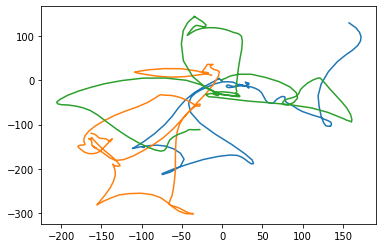

In [15]:
## Example of trajectory
plt.plot(np.cumsum(y[:200,0]),np.cumsum(y[:200,1]))
plt.plot(np.cumsum(y[200:400,0]),np.cumsum(y[200:400,1]))
plt.plot(np.cumsum(y[400:600,0]),np.cumsum(y[400:600,1]))

### Functions for metrics of decoding performance



In [16]:
########## R-squared (R2) ##########

def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """

    R2_list=[] #Initialize a list that will contain the R2s for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute R2 for each output
        y_mean=np.mean(y_test[:,i])
        R2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        R2_list.append(R2) #Append R2 of this output to the list
    R2_array=np.array(R2_list)
    return R2_array #Return an array of R2s

########## Pearson's correlation (rho) ##########

def get_rho(y_test,y_test_pred):

    """
    Function to get Pearson's correlation (rho)

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    rho_array: An array of rho's for each output
    """

    rho_list=[] #Initialize a list that will contain the rhos for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute rho for each output
        y_mean=np.mean(y_test[:,i])
        rho=np.corrcoef(y_test[:,i].T,y_test_pred[:,i].T)[0,1]
        rho_list.append(rho) #Append rho of this output to the list
    rho_array=np.array(rho_list)
    return rho_array #Return the array of rhos
 

### Split into training / testing / validation sets



### (1) Linear decoder

#### Format of input and output

In [16]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]


num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

In [17]:
training_set

array([    6,     7,     8, ..., 42928, 42929, 42930])

In [18]:
testing_set

array([42943, 42944, 42945, ..., 52129, 52130, 52131])

In [19]:
valid_set

array([52144, 52145, 52146, ..., 61330, 61331, 61332])

### Process Covariates
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

In [20]:
def calc_zscores(X):
    X_mean = np.nanmean(X, axis=0)
    X_std = np.nanstd(X, axis=0)
    return (X-X_mean)/X_std
def calc_zerocenter(X):
    return X-np.nanmean(X,axis=0)

In [21]:
#Z-score "X" inputs. 
X_train = calc_zscores(X_train)
X_test = calc_zscores(X_test)
X_valid = calc_zscores(X_valid)
X_flat_train = calc_zscores(X_flat_train)
X_flat_test = calc_zscores(X_flat_test)
X_flat_valid = calc_zscores(X_flat_valid)
#Zero-center outputs
y_train = calc_zerocenter(y_train)
y_test = calc_zerocenter(y_test)
y_valid = calc_zerocenter(y_valid)

In [22]:
print(X_train.shape, X_test.shape, X_valid.shape)
print(X_flat_train.shape, X_flat_test.shape, X_flat_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)

(42925, 13, 52) (9189, 13, 52) (9189, 13, 52)
(42925, 676) (9189, 676) (9189, 676)
(42925, 2) (9189, 2) (9189, 2)


### Linear decoder

In [24]:
class LinearDecoder():
    
    """
    Class for the Linear Decoder. There are no parameters to set.
    This simply leverages the scikit-learn linear regression.
    """
    
    def __init__(self):
        return
    
    
    def fit(self, X_flat_train, y_train):
        
        """
        Train Linear Decoder

        Parameters
        ----------
        X_flat_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """
        
        self.model = linear_model.LinearRegression()  # Initialize linear regression model
        self.model.fit(X_flat_train, y_train)  # Train the model
        
    def predict(self,X_flat_test):

        """
        Predict outcomes using trained Wiener Cascade Decoder

        Parameters
        ----------
        X_flat_test: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted=self.model.predict(X_flat_test) #Make predictions
        return y_test_predicted


#### Run Linear Decoder

In [25]:
#Declare model
model_linear = LinearDecoder()

#Fit model
model_linear.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_linear = model_linear.predict(X_flat_valid)
print(y_valid_predicted_linear.shape)

#Get metric of fit
R2s_linear = get_R2(y_valid,y_valid_predicted_linear)
print('R2s:', R2s_linear)

(9189, 2)
R2s: [0.73731677 0.71696587]


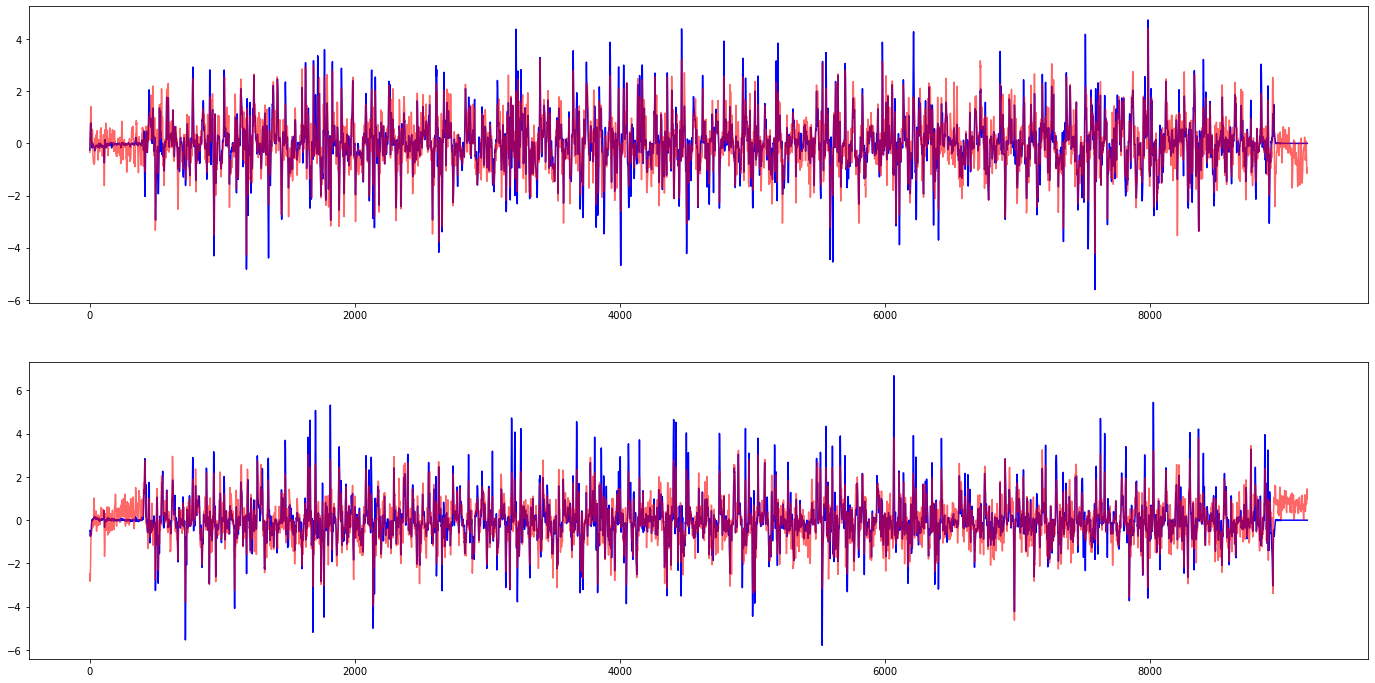

In [26]:
fig = plt.figure(figsize=(24,12))

y_valid = calc_zscores(y_valid)
y_valid_predicted_linear = calc_zscores(y_valid_predicted_linear)
for i in range(y_valid.shape[1]):
    ax = fig.add_subplot(2,1,i+1)
    ax.plot(y_valid[:,i],'b')
    ax.plot(y_valid_predicted_linear[:,i],'r', alpha=.6)

### (2) Kalman filter decoder

#### Format of input and output

In [27]:
## Format of input
X_kf = neural_data


#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine position
pos_binned=np.zeros(vels_binned.shape) #Initialize 
pos_binned[0,:]=0 #Assume starting position is at [0,0]
#Loop through time bins and determine positions based on the velocities
for i in range(pos_binned.shape[0]-1): 
    pos_binned[i+1,0]=pos_binned[i,0]+vels_binned[i,0]*.05 #Note that .05 is the length of the time bin
    pos_binned[i+1,1]=pos_binned[i,1]+vels_binned[i,1]*.05

#We will now determine acceleration    
temp=np.diff(vels_binned,axis=0) #The acceleration is the difference in velocities across time bins 
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

#The final output covariates include position, velocity, and acceleration
y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

In [31]:
print(X_kf.shape, pos_binned.shape, acc_binned.shape, y_kf.shape)

(61339, 52) (61339, 2) (61339, 2) (61339, 6)


In [32]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

In [33]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

/tmp/ipykernel_2402476/735105408.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
/tmp/ipykernel_2402476/735105408.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

In [35]:
print(X_kf_train.shape, X_kf_test.shape, X_kf_valid.shape)
print(y_kf_train.shape, y_kf_test.shape, y_kf_valid.shape)

(42935, 52) (9199, 52) (9199, 52)
(42935, 6) (9199, 6) (9199, 6)


### Kalman filter decoder

In [36]:
class KalmanFilterDecoder():
    
    """
    Class for the Kalman Filter Decoder
    
    Reference: 
    (https://papers.nips.cc/paper/2178-neural-decoding-of-cursor-motion-using-a-kalman-filter.pdf)
    The original implementation has previously been coded in Matlab by Dan Morris (http://dmorris.net/projects/neural_decoding.html#code)

    """

    def __init__(self):
        return

    def fit(self, X_kf_train, y_train):

        """
        Train Kalman Filter Decoder

        Parameters
        ----------
        X_kf_train: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
            This is the neural data in Kalman filter format.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples(i.e. timebins), n_outputs]
            This is the outputs that are being predicted
        """

        #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al, 2003):
        #xs are the state (here, the variable we're predicting, i.e. y_train)
        #zs are the observed variable (neural data here, i.e. X_kf_train)
        X = y_train.T
        Z = X_kf_train.T

        #number of time bins
        nt = X.shape[1]

        #Calculate the transition matrix (from x_t to x_t+1) using least-squares, and compute its covariance
        #In our case, this is the transition from one kinematic state to the next
        X2 = X[:,1:]
        X1 = X[:,0:nt-1]
        A = X2@X1.T@inv(X1@X1.T) #Transition matrix
        W = (X2-A@X1)@(X2-A@X1).T/(nt-1) #Covariance of transition matrix. Note we divide by nt-1 since only nt-1 points were used in the computation (that's the length of X1 and X2). We also introduce the extra parameter C here.

        #Calculate the measurement matrix (from x_t to z_t) using least-squares, and compute its covariance
        #In our case, this is the transformation from kinematics to spikes
        H = Z@X.T@(inv(X@X.T)) #Measurement matrix
        Q = ((Z - H@X)@((Z - H@X).T)) / nt #Covariance of measurement matrix
        params=[A,W,H,Q]
        self.model=params

    def predict(self,X_kf_test,y_test):

        """
        Predict outcomes using trained Kalman Filter Decoder

        Parameters
        ----------
        X_kf_test: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
            This is the neural data in Kalman filter format.

        y_test: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
            The actual outputs
            This parameter is necesary for the Kalman filter (unlike other decoders)
            because the first value is nececessary for initialization

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
            The predicted outputs
        """

        #Extract parameters
        A,W,H,Q=self.model

        #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al):
        #xs are the state (here, the variable we're predicting, i.e. y_train)
        #zs are the observed variable (neural data here, i.e. X_kf_train)
        X = y_test.T
        Z = X_kf_test.T

        #Initializations
        num_states = X.shape[0] #Dimensionality of the state
        states = np.empty(X.shape) #Keep track of states over time (states is what will be returned as y_test_predicted)
        P_m = np.zeros([num_states,num_states])
        P = np.zeros([num_states,num_states])
        state=X[:,0] #Initial state
        states[:,0]=np.copy(np.squeeze(state))

        #Get predicted state for every time bin
        for t in range(X.shape[1]-1):
            #Do first part of state update - based on transition matrix
            P_m=A@P@A.T+W
            state_m=A@state

            #Do second part of state update - based on measurement matrix
            K=P_m@H.T@inv(H@P_m@H.T+Q) #Calculate Kalman gain
            P=(np.eye(num_states)-K@H)@P_m
            state=state_m+K@(Z[:,t+1]-H@state_m)
            states[:,t+1]=np.squeeze(state) #Record state at the timestep
        y_test_predicted=states.T
        return y_test_predicted

#### Run Kalman Filter Decoder

In [37]:
#Declare model
model_kf = KalmanFilterDecoder() 

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

R2: [0.69338203 0.65576081]
rho2: [0.7075872  0.66082442]


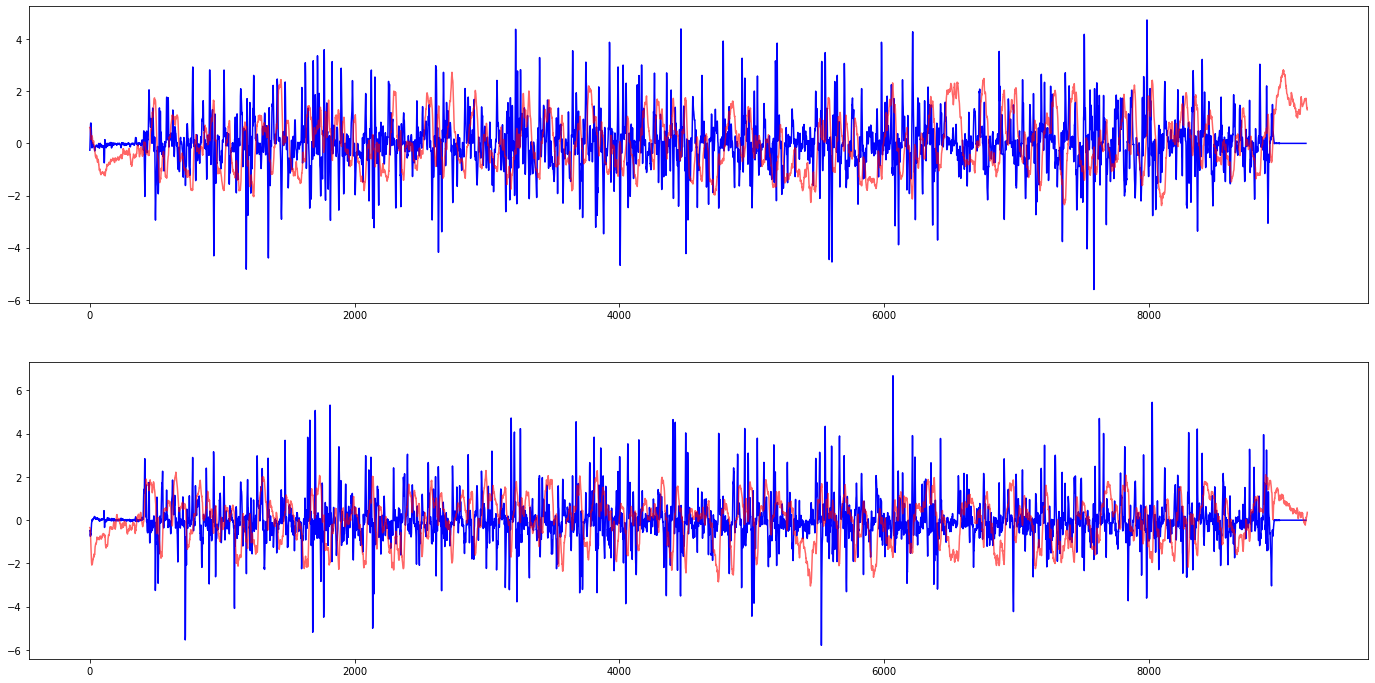

In [38]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig = plt.figure(figsize=(24,12))

y_valid = calc_zscores(y_valid)
y_valid_predicted_kf = calc_zscores(y_valid_predicted_kf)
for i in range(y_valid.shape[1]):
    ax = fig.add_subplot(2,1,i+1)
#     plt.plot(y_valid[1000:2000,0]+y_train_mean[0],'b')
    
    ax.plot(y_valid[:,i],'b')
#     plt.plot(y_valid_predicted_wf[1000:2000,0]+y_train_mean[0],'r')
    ax.plot(y_valid_predicted_kf[:,i],'r', alpha=.6)

#Save figure
# fig.savefig('x_velocity_decoding.eps')

## Preprocessing

In [17]:
import pandas as pd

df_X = pd.DataFrame()

for i in range(52):
    df_X['channel%02d'%(i+1)] = neural_data[:,i]
df_X

,channel01,channel02,channel03,channel04,channel05,channel06,channel07,channel08,channel09,channel10,...,channel43,channel44,channel45,channel46,channel47,channel48,channel49,channel50,channel51,channel52
0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61334,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61335,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61336,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61337,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
## Normalizing Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xcol = ['channel%02d'%(i+1) for i in range(52)]
df_X[xcol] = scaler.fit_transform(df_X[xcol])

df_X

,channel01,channel02,channel03,channel04,channel05,channel06,channel07,channel08,channel09,channel10,...,channel43,channel44,channel45,channel46,channel47,channel48,channel49,channel50,channel51,channel52
0,-0.255168,-0.380935,-0.394391,0.195975,6.015961,-0.773340,-0.641151,0.139745,-0.726614,0.919512,...,-0.473000,-0.091189,-0.661074,2.252738,-0.236668,0.755698,-0.077948,-0.252905,-0.265816,1.167356
1,-0.255168,-0.380935,2.005564,0.195975,-0.290660,0.108926,-0.641151,-1.327525,0.850128,-0.769852,...,1.246309,-0.091189,-0.661074,-0.428196,-0.236668,-0.664411,-0.077948,-0.252905,-0.265816,1.167356
2,-0.255168,-0.380935,-0.394391,0.195975,-0.290660,-0.773340,0.697341,0.139745,0.850128,-0.769852,...,-0.473000,-0.091189,-0.661074,-0.428196,-0.236668,-0.664411,-0.077948,-0.252905,-0.265816,1.167356
3,-0.255168,-0.380935,-0.394391,-1.093820,-0.290660,0.108926,0.697341,1.607014,2.426869,-0.769852,...,-0.473000,-0.091189,-0.661074,-0.428196,-0.236668,-0.664411,-0.077948,2.524707,-0.265816,-0.480618
4,-0.255168,-0.380935,-0.394391,-1.093820,2.862650,-0.773340,-0.641151,-1.327525,-0.726614,0.074830,...,-0.473000,-0.091189,-0.661074,-0.428196,-0.236668,-0.664411,-0.077948,-0.252905,-0.265816,1.167356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61334,-0.255168,-0.380935,-0.394391,0.195975,-0.290660,0.991192,-0.641151,0.139745,-0.726614,-0.769852,...,-0.473000,-0.091189,0.540645,-0.428196,-0.236668,-0.664411,-0.077948,-0.252905,-0.265816,-0.480618
61335,-0.255168,-0.380935,2.005564,-1.093820,2.862650,0.991192,-0.641151,-1.327525,2.426869,-0.769852,...,-0.473000,-0.091189,-0.661074,-0.428196,-0.236668,-0.664411,-0.077948,-0.252905,-0.265816,1.167356
61336,-0.255168,-0.380935,-0.394391,0.195975,-0.290660,0.108926,-0.641151,0.139745,-0.726614,-0.769852,...,-0.473000,-0.091189,0.540645,-0.428196,-0.236668,0.755698,-0.077948,-0.252905,-0.265816,-0.480618
61337,-0.255168,-0.380935,-0.394391,-1.093820,2.862650,0.108926,-0.641151,-1.327525,-0.726614,-0.769852,...,-0.473000,-0.091189,-0.661074,-0.428196,-0.236668,-0.664411,-0.077948,-0.252905,2.905726,-0.480618


In [19]:
df_y = pd.DataFrame()

df_y['vel_x'] = vels_binned[:,0]
df_y['vel_y'] = vels_binned[:,1]

df_y

,vel_x,vel_y
0,1.510374e-01,1.509124e-01
1,-1.394984e-01,1.100643e-01
2,-3.557739e-01,-3.964327e-01
3,-2.432974e-01,-2.767266e-01
4,-2.141815e-02,1.988299e-01
...,...,...
61334,-9.545068e-07,5.324428e-07
61335,-2.458964e-06,1.281984e-06
61336,3.197229e-06,-1.327228e-06
61337,7.248145e-07,3.014045e-06


In [20]:
## Data Normalizing

ycol = ['vel_x', 'vel_y']

df_y[ycol] = scaler.fit_transform(df_y[ycol])
df_y

,vel_x,vel_y
0,0.019979,0.019882
1,-0.018280,0.014551
2,-0.046760,-0.051546
3,-0.031949,-0.035925
4,-0.002731,0.026135
...,...,...
61334,0.000090,0.000188
61335,0.000090,0.000188
61336,0.000090,0.000188
61337,0.000090,0.000188


In [21]:
## Selecting Data
import torch
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X
                                                    , df_y
                                                    , test_size=0.2
                                                    , random_state=42
                                                    , shuffle=False)
X_train = torch.tensor(np.array(X_train), dtype=torch.float)
X_test = torch.tensor(np.array(X_test), dtype=torch.float)
y_train = torch.tensor(np.array(y_train), dtype=torch.float)
y_test = torch.tensor(np.array(y_test), dtype=torch.float)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([49071, 52]) torch.Size([49071, 2]) torch.Size([12268, 52]) torch.Size([12268, 2])


### (3) Bayesian decoder

이 섹션에서는 Bayes' rulle 을 적용하여 각 자극에 대한 posterior probability를 얻어 학습하는 머신러닝에 대해서 다룬다.

$$p(x|D)\propto p(D|x)p(x)$$

여기서 $p(x)$는 prior stimulus probability 이다. 이와 별도로 인코딩 모델의 매개변수 $\theta$의 추정치를 정규화하기 위해 prior knowledge를 통합했을 때의 아이디어와 비슷한 방식이 사용됨에 주목한다면, 이 $\theta$ 혹은 이와 동등한 $p(D|x)$가 상당한 정밀도로 유추 가능할 것이고 자극 $x$에 대한 prior knowledge도 통합될 것이다.

이러한 베이지안 디코딩 방법의 주된 매력은 인코딩 모델 $p(D|x)$가 정확하다고 가정하면 최적의 접근법이라는 점이다. 따라서 디코딩은 응답에 의해 보존되는 자극의 측면을 조사하는 수단이자 다른 인코딩 모델을 비교하는 도구로도 사용된다. 예를 들어, 우리는 다른 모델(예, including vs. ignoring spike-history effects)을 사용하여 spike train을 디코딩하고 어떤 인코딩 모델이 실제 자극을 가장 잘 디코딩 할 수 있는지 조사할 수 있다. 즉 이러한 테스트는 원칙적으로 spike train 통계를 예측하는 인코딩 모델의 능력에 초점을 맞춘 비교와는 다른 결과를 제공하게 된다. 

In [22]:
## Bayesian Network
from torch import nn
# from blitz.modules import BayesianLSTM
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

@variational_estimator
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(input_dim, 10),
            nn.ReLU(),
            BayesianLinear(10, 5),
            nn.ReLU(),
            BayesianLinear(5, output_dim)
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [23]:
import torch.optim as optim

model = Model(input_dim=len(xcol), output_dim=len(ycol))
criterio = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
print(model)

Model(
  (layer): Sequential(
    (0): BayesianLinear(
      (weight_sampler): TrainableRandomDistribution()
      (bias_sampler): TrainableRandomDistribution()
      (weight_prior_dist): PriorWeightDistribution()
      (bias_prior_dist): PriorWeightDistribution()
    )
    (1): ReLU()
    (2): BayesianLinear(
      (weight_sampler): TrainableRandomDistribution()
      (bias_sampler): TrainableRandomDistribution()
      (weight_prior_dist): PriorWeightDistribution()
      (bias_prior_dist): PriorWeightDistribution()
    )
    (3): ReLU()
    (4): BayesianLinear(
      (weight_sampler): TrainableRandomDistribution()
      (bias_sampler): TrainableRandomDistribution()
      (weight_prior_dist): PriorWeightDistribution()
      (bias_prior_dist): PriorWeightDistribution()
    )
  )
)


In [24]:
## model test
x = torch.rand(250, 52)
print('input_dim: ', x.shape)
y = model(x)
print('output_dim: ',y.shape)

input_dim:  torch.Size([250, 52])
output_dim:  torch.Size([250, 2])


#### Run Bayesian Decoder

In [25]:
for epoch in range(1000):
#     predict_y = model(X_train)
#     loss = criterio(y_train.reshape(-1,1), predict_y)
    loss = model.sample_elbo(inputs=X_train,
                             labels=y_train,
                             criterion=criterio,
                             sample_nbr=3,
                             complexity_cost_weight=1./X_train.shape[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(loss)

tensor(1.0876, grad_fn=<DivBackward0>)
tensor(0.5108, grad_fn=<DivBackward0>)
tensor(0.4909, grad_fn=<DivBackward0>)
tensor(0.4826, grad_fn=<DivBackward0>)
tensor(0.4775, grad_fn=<DivBackward0>)
tensor(0.4739, grad_fn=<DivBackward0>)
tensor(0.4705, grad_fn=<DivBackward0>)
tensor(0.4687, grad_fn=<DivBackward0>)
tensor(0.4680, grad_fn=<DivBackward0>)
tensor(0.4663, grad_fn=<DivBackward0>)


In [26]:
y_pred = model(X_test).detach().clone().numpy()
test = y_test.numpy()

## Coefficient of Determination ##
R2: [0.53828928 0.60704625]
rho2: [0.54423011 0.60921501]


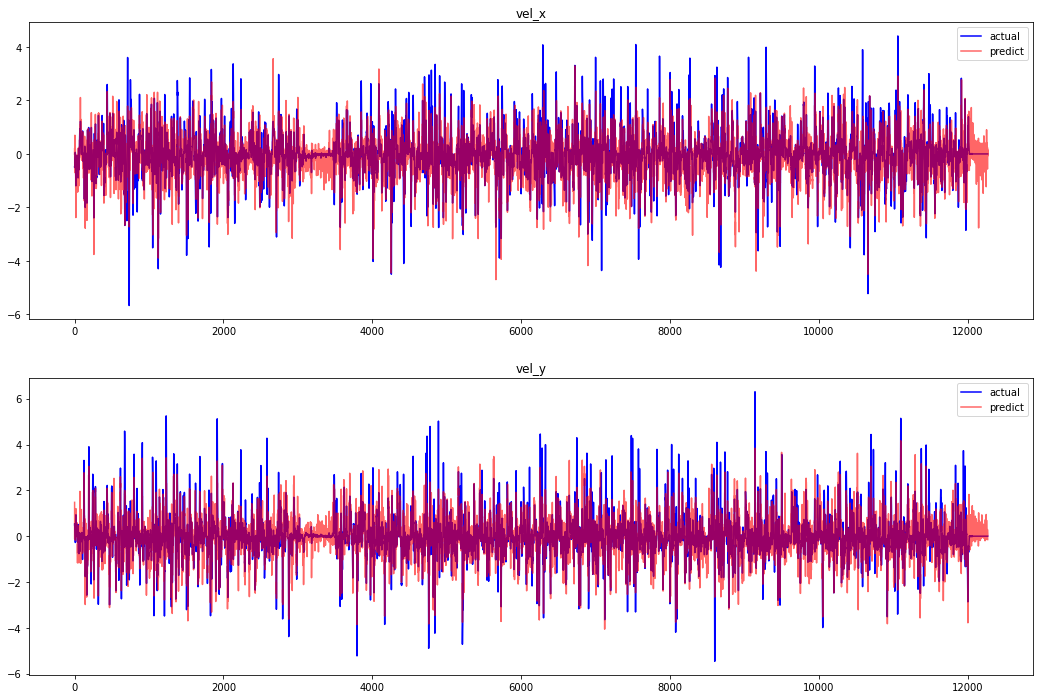

In [27]:
print('## Coefficient of Determination ##')
R2=get_R2(test,y_pred)
print('R2:',R2)
rho=get_rho(test,y_pred)
print('rho2:',rho**2)

fig = plt.figure(figsize=(18,12))

for i in range(len(ycol)):
    ax = fig.add_subplot(len(ycol),1,i+1)
    ax.plot(test[:,i].reshape(-1), color='b', label='actual')
    ax.plot(y_pred[:,i], 'r-', label='predict', alpha=.6)

#     ci = 1.96* np.std(y_pred[:,i])/np.sqrt(y_pred.shape[0])
#     print(ci)
#     ax.fill_between(x=range(y_pred.shape[0]),y1=y_pred[:,i]-ci, y2=y_pred[:,i]+ci, color='g', label='Confidence Interval', alpha=.5)
    
    ax.set_title(ycol[i])
    ax.legend()

### (4) RNN decoder

가장 간단한 순환 신경망(Recurrent Neural Network, RNN)을 통하여 many-to-two (spike-to-movement) 모델을 설계한다.

In [28]:
## RNN Network
from torch import nn

input_size = len(xcol)
hidden_size = len(ycol)

class model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(model, self).__init__()
        
        self.cell = nn.RNN(input_size, hidden_size, dropout=0, num_layers=1, batch_first=True)

    def forward(self, x):
        x, _ = self.cell(x)

        return x

In [29]:
import torch.optim as optim

ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = model(len(xcol), len(ycol))
print(net)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

model(
  (cell): RNN(52, 2, batch_first=True)
)


In [30]:
## model test
x = torch.rand(1, 250, 52)
print('input_dim: ', x.shape)
y = net(x)
print('output_dim: ',y.shape)

input_dim:  torch.Size([1, 250, 52])
output_dim:  torch.Size([1, 250, 2])


#### Run RNN Decoder

In [31]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(dataloader_train)

iter = 0
for epoch in range(10):
    running_loss = 0.0
    
    for i, (datapoints, labels) in enumerate(dataloader_train):
        out = net(datapoints.unsqueeze(dim=0))
        loss = criterion(out, labels.unsqueeze(dim=0))
        
        optimizer.zero_grad()
        loss.backward() # loss가 최소가 되게하는
        optimizer.step() # 가중치 업데이트 해주고,
        running_loss += loss.item() # 한 배치의 loss 더해주고,
        
    loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
    if epoch % 1 == 0:
        print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.9344
[epoch: 1] loss: 0.6182
[epoch: 2] loss: 0.6073
[epoch: 3] loss: 0.6071
[epoch: 4] loss: 0.6057
[epoch: 5] loss: 0.6058
[epoch: 6] loss: 0.6059
[epoch: 7] loss: 0.6061
[epoch: 8] loss: 0.6060
[epoch: 9] loss: 0.6060


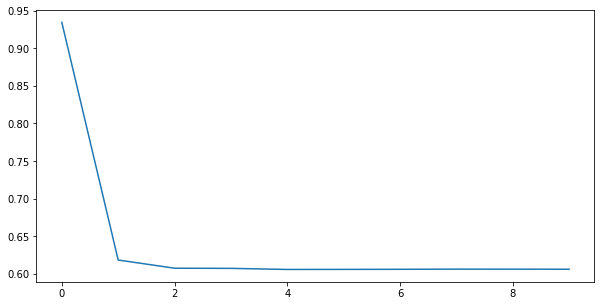

In [32]:
plt.figure(figsize=(10,5))
plt.plot(loss_graph)
plt.show()

In [33]:
y_pred = net(X_test.unsqueeze(dim=0))[0].detach().clone().numpy()

In [34]:
test = y_test.numpy()

## Coefficient of Determination ##
R2: [0.42003   0.4324472]
rho2: [0.42382267 0.44157587]


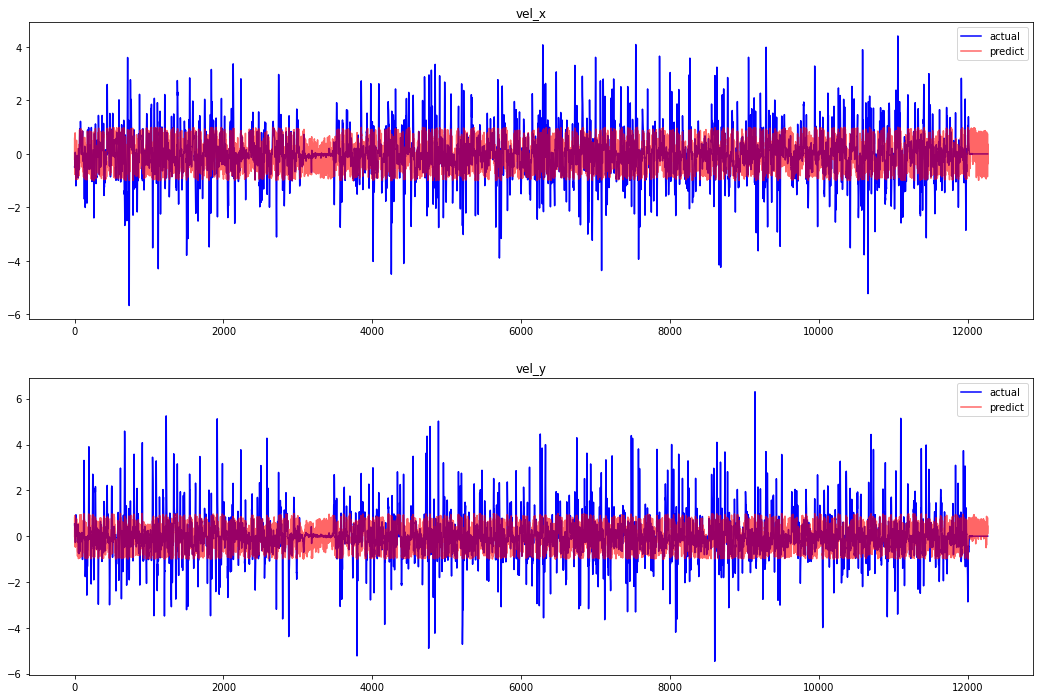

In [35]:
print('## Coefficient of Determination ##')
R2=get_R2(test,y_pred)
print('R2:',R2)
rho=get_rho(test,y_pred)
print('rho2:',rho**2)

fig = plt.figure(figsize=(18,12))

for i in range(len(ycol)):
    ax = fig.add_subplot(len(ycol),1,i+1)
    ax.plot(test[:,i], color='b', label='actual')
    ax.plot(y_pred[:,i], 'r-', label='predict', alpha=.6)

#     ci = 1.96* np.std(y_pred[:,i])/np.sqrt(y_pred.shape[0])
#     print(ci)
#     ax.fill_between(x=range(y_pred.shape[0]),y1=y_pred[:,i]-ci, y2=y_pred[:,i]+ci, color='g', label='Confidence Interval', alpha=.5)
    
    ax.set_title(ycol[i])
    ax.legend()

### Save Data

In [12]:
data_folder='./Decoding_Data/' #FOLDER YOU WANT TO SAVE THE DATA TO

with open(data_folder+'example_data_s1.pickle','wb') as f:
    pickle.dump([neural_data,vels_binned],f)

### Load Data

In [35]:
data_folder='./Decoding_Data/'

with open(data_folder+'example_data_s1.pickle','rb') as f:
    [neural_data, vels_binned] = pickle.load(f)